In [7]:
import os
import yfinance as yf
import datetime as dt
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import feather
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('fivethirtyeight')

In [ ]:
- Get daily pricing data
- Resample into monthly return
- Create a DF of monthly returns. The shape should be: Date,SymbolA,SymbolB
- QCut each month to assign a bucket to each symbol/column

In [55]:
df = pd.read_csv('sp100.csv',index_col=0)
tickers =  [i.replace('.','-') for i in df.Symbol.to_list()]

file = 'datasets/sp100.parquet'
if not os.path.isfile(file):
    df = yf.download(tickers,start='2005-01-01',auto_adjust=True,progress=False)
    # Or use the monthly option
    # dl = yf.download(tickers, session=session, interval='1mo', start='2005-01-01')
    df.to_parquet('datasets/sp100.parquet')
df = pd.read_parquet('datasets/sp100.parquet')
prices = df.Close
prices.index = pd.to_datetime(prices.index)
monthly_rets = prices.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)

In [84]:
# Make a data frame with prior months as a column
formation_dt = dt.datetime(2021,7,31)
prior_monthly_rets = pd.DataFrame({'returns':monthly_rets.loc[formation_dt - MonthEnd(1)]})

# Bucket returns - This works for a single month
prior_monthly_rets['decile'] = pd.qcut(prior_monthly_rets.returns, 20, labels=False)
losers = prior_monthly_rets[prior_monthly_rets.decile == 0].index
losers_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(losers)].mean()
losers_ret

In [56]:
# Create a DF of monthly returns for each qtile using melt
# DF should be monthly end date, symbol1, symbol2
def melting(monthly_rets, bins):
    monthly_rets = monthly_rets.dropna()
    monthly_qtiles = monthly_rets.apply(lambda x: pd.qcut(x, bins, labels=False, duplicates='drop'), axis=1)
    df0 = monthly_qtiles.melt(ignore_index=False)
    df0.columns = ['symbol', 'qtile']
    df1 = monthly_rets.melt(ignore_index=False)
    df1.columns = ['symbol', 'pchange']
    df = pd.merge(left=df0, right=df1, on=['Date', 'symbol'])
    df.reset_index(inplace=True)
    df['date_prev'] = df.Date - MonthEnd(1)
    df = pd.merge(left=df, right=df[['date_prev', 'symbol', 'pchange', 'qtile']], left_on=['Date', 'symbol'], right_on=['date_prev', 'symbol'], suffixes=[None,'_prev'])    
    #pdf = pd.pivot_table(df, index='Date', columns='qtile', values='pchange', aggfunc=np.mean)
    #df.groupby(['Date', 'qtile'])['pchange'].mean()
    return df

# WIP
def dog_strategy(monthly_rets, bin_idx, total_bins):
    pdf, df = melting(monthly_rets, total_bins)
    df['date_prev'] = df.Date - MonthEnd(1)
    xdf = pd.merge(left=df, right=df[['date_prev', 'symbol', 'returns', 'qtile']], left_on=['Date', 'symbol'], right_on=['date_prev', 'symbol'], suffixes=[None,'_prev'])
    returns = pd.pivot_table(xdf, index='Date', columns='qtile_prev', values='returns', aggfunc=np.mean)
    symbols = df[(df.Date == '2021-01-31') & (df.qtile == bin_idx)].symbol.values.tolist()
    df[ (df.Date == '2021-02-28') & (df.symbol.isin(symbols)) ]['returns'].mean()


In [ ]:
# The method used in the video
def monthly_decile(formation_dt, decile, monthly_rets):
    df = monthly_rets.loc[formation_dt - MonthEnd(1)].copy()
    df.name = 'returns'
    df = pd.DataFrame(df)
    df['decile'] = pd.qcut(df.returns, 20, labels=False, duplicates='drop')
    symbols = df[df.decile == decile].index
    decile_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(symbols)].mean()
    return decile_ret, symbols.values.tolist()

returns = []
dates = monthly_rets[2:].index

for dt in dates:
    decile_returns = []
    returns.append(decile_returns)
    for decile in range(0,20):
        decile_returns.append(monthly_decile(dt, decile, monthly_rets)[0])

df = pd.DataFrame(returns)
df.index = dates
df.to_csv('wip.csv')
df.describe()

In [58]:
spy = yf.download('SPY',start='2005-01-01', progress=False)
spy = spy['Adj Close']
spy_rets = spy.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)
df['spy']  = spy_rets[2:].values
df.to_csv('wip.csv')

ValueError: Length of values (198) does not match length of index (4173)

In [ ]:
print(df.columns)
subplots_ratio = dict(width_ratios=[3,3], height_ratios=[1])

bins1 = ['0', '1', '2', '3', '4', 'spy']
bins2 = ['5', '6', '7', '8', '9', 'spy']
bins3 = ['10', '11', '12', '13', '14', 'spy']
bins4 = ['15', '16', '17', '18', '19', 'spy']

xdf = pd.read_csv('wip.csv', index_col='Date', parse_dates=True)
xdf = xdf[xdf.index > '2018-01-01']

fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(20,5))
((1 + xdf[bins1]).cumprod() - 1).plot(title='Strategy Performance',ax=ax[0])
((1 + xdf[bins2]).cumprod() - 1).plot(title='Strategy Performance',ax=ax[1])

plt.show()

qtile_prev,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,spy
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.03,-0.03,-0.03,-0.03,-0.01,-0.01,-0.01,-0.00,0.03,-0.02,...,0.00,0.02,-0.02,-0.06,-0.03,-0.03,0.03,NaN,NaN,-0.02
2005-02-28,-0.02,0.11,0.04,0.00,-0.02,0.04,0.04,-0.03,0.02,0.00,...,0.01,0.01,-0.01,-0.00,0.05,0.03,0.05,NaN,NaN,0.02
2005-03-31,-0.02,-0.04,-0.07,-0.02,-0.03,-0.00,-0.02,-0.01,-0.02,0.01,...,0.00,0.03,-0.01,-0.01,0.00,-0.03,-0.03,NaN,NaN,-0.02
2005-04-30,0.01,0.01,-0.01,-0.03,0.01,-0.00,0.02,0.02,-0.01,-0.07,...,-0.04,-0.05,-0.01,-0.09,-0.06,-0.04,0.08,NaN,NaN,-0.02
2005-05-31,0.07,0.07,0.04,0.01,0.05,0.02,0.09,0.01,0.02,0.01,...,0.07,0.03,0.06,0.01,0.11,0.06,0.06,NaN,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,0.03,-0.01,0.04,0.10,0.07,0.06,0.04,0.09,0.03,0.14,...,0.10,0.03,-0.00,-0.02,-0.01,0.10,0.05,-0.04,0.01,0.03
2021-03-31,0.10,0.08,-0.00,0.07,0.08,0.03,0.10,0.08,0.06,0.09,...,0.07,0.08,0.07,0.04,0.07,0.03,0.03,0.03,0.05,0.05
2021-04-30,0.07,0.05,0.04,0.06,0.02,0.04,0.05,0.06,0.01,0.04,...,0.01,0.06,0.04,0.01,0.04,0.05,0.08,0.01,-0.00,0.05


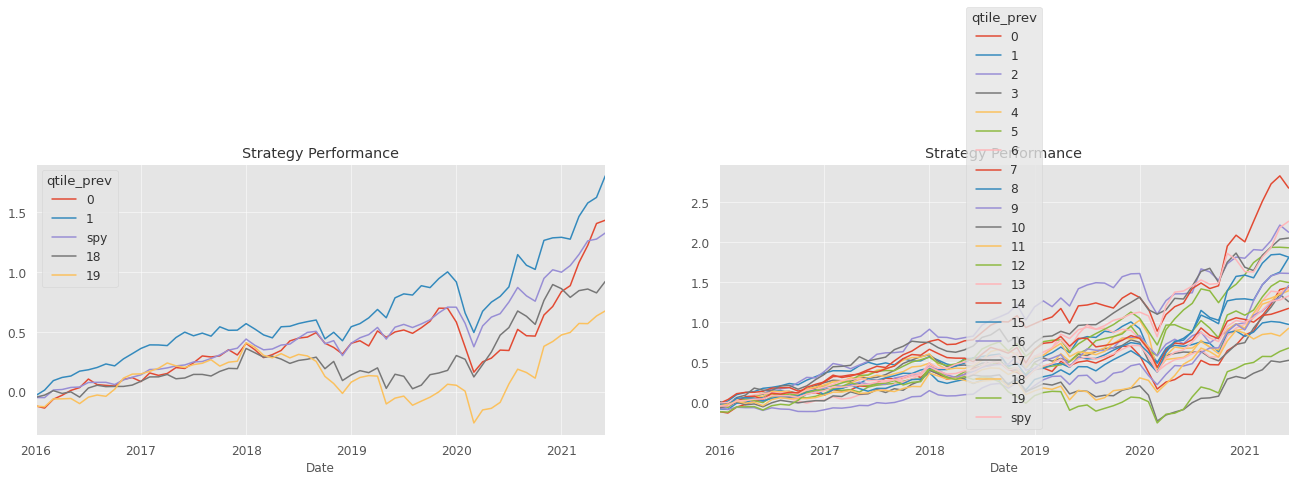

In [60]:
plt.style.use('seaborn-pastel')
plt.style.use('ggplot')

melted_rets = melting(monthly_rets, 20)
lag_rets = pd.pivot_table(melted_rets, index='Date', columns='qtile_prev', values='pchange', aggfunc=np.mean)
lag_rets['spy'] = spy_rets[spy_rets.index <= '2021-06-30']
cumrets = ((1 + lag_rets[lag_rets.index > '2016-01-01']).cumprod() - 1)

subplots_ratio = dict(width_ratios=[3,3], height_ratios=[1])
fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(20,5))
cumrets[ [0,1,'spy',18,19] ].plot(title='Strategy Performance',ax=ax[0])
cumrets.plot(title='Strategy Performance',ax=ax[1])
lag_rets

date
2020-01-02    9.23
2020-01-03   10.65
2020-01-06    5.36
2020-01-07    5.88
2020-01-08    7.04
              ... 
2021-08-02    0.00
2021-08-03    0.32
2021-08-04    0.14
2021-08-05    0.00
2021-08-06    0.15
Name: IVR, Length: 403, dtype: float64

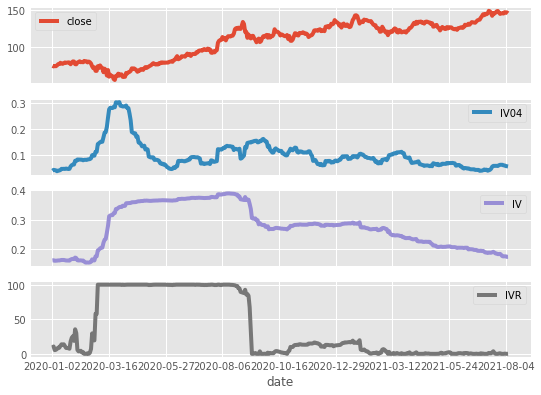

In [50]:
plt.style.use('ggplot')
symbol = 'AAPL'
prices=pd.read_csv(f'datasets/{symbol}.csv.gz', index_col=0)
prices['log_rets'] = (np.log(prices.close / prices.close.shift(1)))
prices['IV04'] = prices.log_rets.rolling(window=20).std() * np.sqrt(20)
days= int(252/2)
prices['IV'] = prices.log_rets.rolling(window=days).std() * np.sqrt(days)
mins = prices.IV.rolling(window=days).min()
maxs = prices.IV.rolling(window=days).max()
prices['IVR'] = ((prices.IV - mins) / (maxs - mins)) * 100
df = prices[prices.index > '2020-01-01' ]
df[['close', 'IV04', 'IV', 'IVR']].plot(subplots=True, figsize=(8,6))
df.IVR

In [52]:
import quantstats as qs
qs.extend_pandas()
stock = qs.utils.download_returns('FB')
stock.sharpe()
stock

Note: you may need to restart the kernel to use updated packages.


Date
2012-05-18     NaN
2012-05-21   -0.11
2012-05-22   -0.09
2012-05-23    0.03
2012-05-24    0.03
              ... 
2021-08-02   -0.01
2021-08-03   -0.00
2021-08-04    0.02
2021-08-05    0.01
2021-08-06    0.00
Name: Close, Length: 2320, dtype: float64

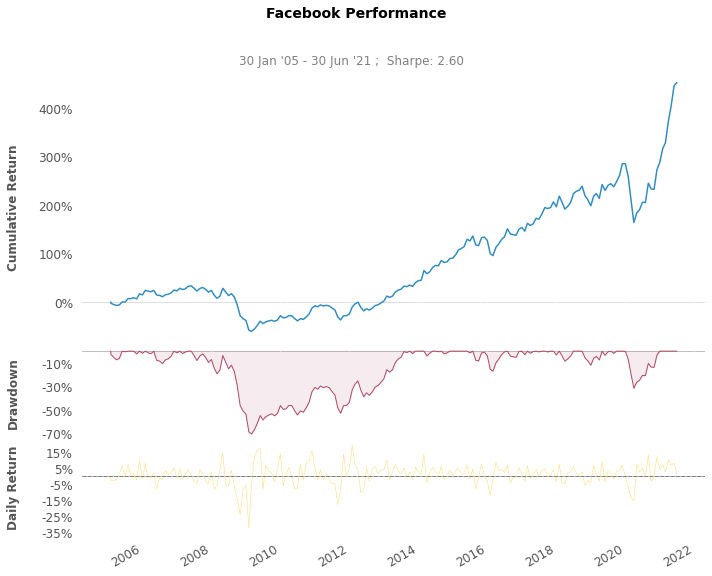

In [69]:
df = lag_rets[lag_rets.index > '2011-01-01']
qs.reports.html(df[0], title='Monthly 5 Dogs S&P100')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.36,2019-12-31,2020-03-31,2020-08-31,175
1,21.30,2011-01-31,2011-09-30,2012-03-31,305
2,11.46,2015-04-30,2015-09-30,2016-03-31,241
3,10.87,2018-09-30,2018-12-31,2019-03-31,130
4,8.13,2012-03-31,2012-05-31,2012-09-30,130


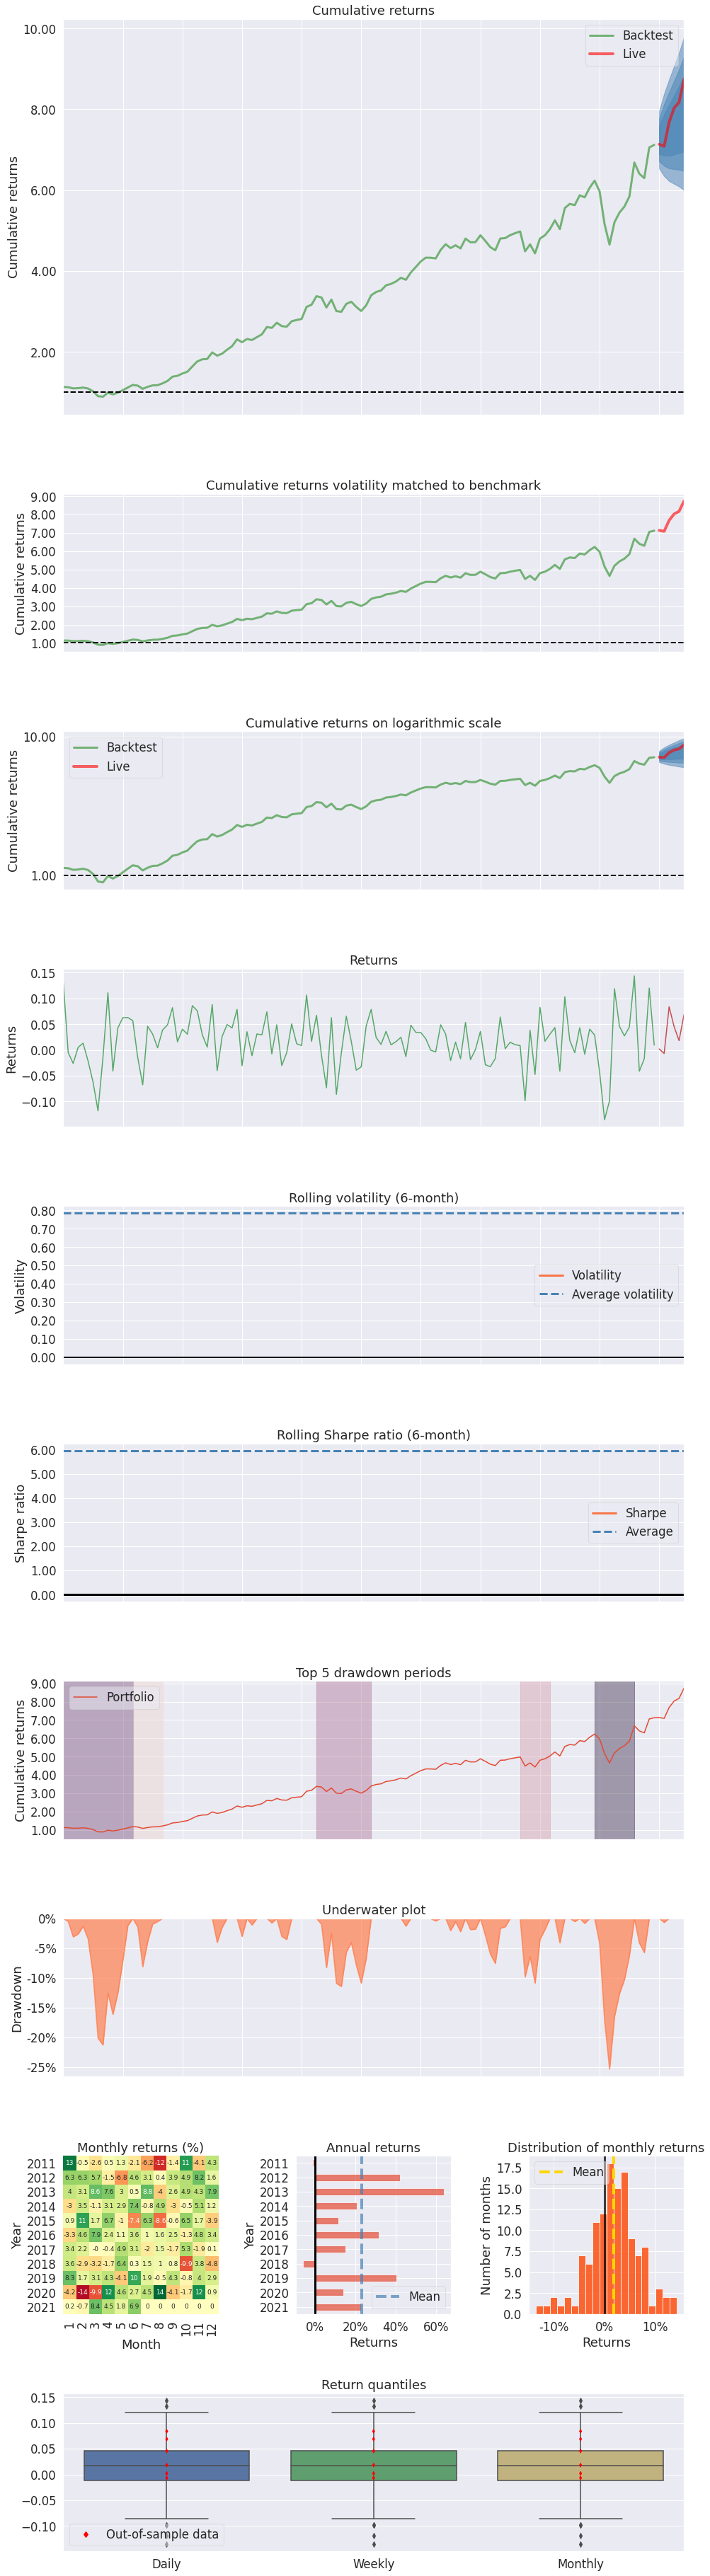

In [80]:
# silence warnings
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf
pdf = lag_rets[lag_rets.index > '2011-01-01'].copy()
pdf.index = pdf.index.tz_localize('utc')
pf.create_returns_tear_sheet(pdf[1], live_start_date='2021-1-1')